# Participez à la conception d'une voiture autonome

In [1]:
import warnings
warnings.simplefilter(action='ignore')
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0,1,2" # warning
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
import segmentation_models as sm
import cv2
from collections import namedtuple
from timeit import default_timer as timer

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

sm.set_framework('tf.keras')
sm.framework()


Segmentation Models: using `keras` framework.


'tf.keras'

## Accès aux données

In [2]:
main_df = pd.DataFrame(columns=['split', 'original_image_path', 'labeled_image_path'])

original_imgs_path = "./data/leftImg8bit"

cities = {"train":[dirs for root, dirs, files in os.walk("/".join([original_imgs_path, "train"]))][0],
          "test": [dirs for root, dirs, files in os.walk("/".join([original_imgs_path, "test"]))][0],
          "val": [dirs for root, dirs, files in os.walk("/".join([original_imgs_path, "val"]))][0]}

for split in ["train", "test", "val"]:
    for city in cities[split]:
        tmp_path = "/".join([original_imgs_path, split, city])
        lbl_tmp_path = tmp_path.replace("leftImg8bit", "gtFine")
        for _, _, files in os.walk(tmp_path):
            for name in files:
                if name.endswith(("_leftImg8bit.png")):
                    img_path = "/".join([tmp_path, name])
                    # lbl_img_path = "/".join([lbl_tmp_path, name]).replace("leftImg8bit", "gtFine_color")
                    lbl_img_path = "/".join([lbl_tmp_path, name]).replace("leftImg8bit", "gtFine_labelIds")
                    main_df = main_df.append({"split": split,
                                              "original_image_path": img_path,
                                              "labeled_image_path": lbl_img_path}, ignore_index=True)


In [3]:
Label = namedtuple('Label', ['name', 'id', 'trainId', 'category', 'categoryId', 'hasInstances', 'ignoreInEval', 'color',])

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'flat'            , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'flat'            , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'flat'            , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'flat'            , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , -1 ,       -1 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

id2label = {label.id: label for label in labels}

color_map = {
 0: (0, 0, 0),
 1: (153, 153, 0),
 2: (255, 204, 204),
 3: (255, 0, 127),
 4: (0, 255, 0),
 5: (0, 204, 204),
 6: (255, 0, 0),
 7: (0, 0, 255)
}


In [14]:
display_dim = (700, 350)

def make_colors(img):
    rows, cols = img.shape
    color_img = np.empty([rows, cols, 3], dtype=np.uint8)
    for y in range(rows):
        for x in range(cols):
            color_img[y][x] = np.asarray(color_map[id2label[img[y][x]].categoryId])
    return color_img
    
def display_imgs(img1, img2, img3=None):
    r_img = cv2.resize(img1, display_dim, interpolation = cv2.INTER_AREA)
    r_img2 = cv2.resize(img2, display_dim, interpolation = cv2.INTER_AREA)
    r_color_img = make_colors(r_img2)
    stack_img = cv2.addWeighted(r_img, 1, r_color_img, 0.4, 0)
    
    if img3 is not None:
        r_img3 = cv2.resize(img3, display_dim, interpolation = cv2.INTER_AREA)
        r_color_img2 = make_colors(r_img3)
        stack_img2 = cv2.addWeighted(r_img, 1, r_color_img2, 0.4, 0)
        numpy_vertical_concat = np.concatenate((r_img, stack_img, stack_img2), axis=0)
    else:
        numpy_vertical_concat = np.concatenate((r_img, stack_img), axis=0)
    
    cv2.imshow('Images', numpy_vertical_concat)
    cv2.waitKey(0)
    
def example_display(loc=0):
    img1 = cv2.imread(main_df.iloc[loc]["original_image_path"]) # img shape: (2048, 1024)        
    img2 = cv2.imread(main_df.iloc[loc]["labeled_image_path"], cv2.IMREAD_GRAYSCALE)
    display_imgs(img1, img2)
    
# example_display()

## Modèles

### Préparation

In [5]:
train_df = main_df[main_df["split"]=="train"]
val_df = main_df[main_df["split"]=="val"]

In [6]:
n_epochs = 20

batch_size = 8

data_passes = 200

steps_per_epoch = (train_df.shape[0] * data_passes) // (batch_size * n_epochs)

AUTOTUNE = tf.data.AUTOTUNE

BUFFER_SIZE = 1000

trained = 0

print(f"Training with {steps_per_epoch} steps per epoch")

Training with 371 steps per epoch


In [7]:
results_file = f'./results.csv'

if not os.path.isfile(results_file):
    results = pd.DataFrame(columns=['model_name', 'accuracy', 'time', 'loss'])
    results.to_csv(results_file, index=False)

def add_result(name, accuracy, time, loss=None):
    result_df = pd.read_csv(results_file)
    result_df = result_df[result_df["model_name"] != name]
    result_df = result_df.append({"model_name": name, "accuracy": accuracy, "time": time, "loss": loss}, ignore_index=True)
    result_df.to_csv(results_file, index=False)
    
def get_results():
    result_df = pd.read_csv(results_file)
    print(result_df.head(20))
    
def process_model(model, hist, name, time):
    history = pd.DataFrame(data=hist.history)
    # model.save(f"./models/{name}.h5")
    model.save_weights(f'./models/{name}_weights.h5')
    history.to_csv(f'./models/{name}_history.csv', index=False)
    # add_result(name, model_performance[1], time) # warning
    
def display_learning_curves(m_name, metric):
    hst = pd.read_csv(f'./models/{m_name}_history.csv')
    fig, ax = plt.subplots(1, 2, figsize=(20, 3))
    ax = ax.ravel()

    for i, met in enumerate([metric, 'loss']):
        ax[i].plot(hst[met])
        ax[i].plot(hst['val_' + met])
        ax[i].set_title('Model {}'.format(met))
        ax[i].set_xlabel('epochs')
        ax[i].set_ylabel(met)
        ax[i].legend(['train', 'val'])
    
    plt.show()

In [8]:
size = (224, 224)

def load_cropped_imgs(path1, path2):
    img1 = tf.io.read_file(path1)
    img1 = tf.io.decode_png(img1)

    
    img2 = tf.io.read_file(path2)
    img2 = tf.io.decode_png(img2)

    img1 = tf.cast(img1, tf.float32) / 255.
    img2 = tf.cast(img2, tf.float32) / 255.
    
    image_shape = tf.shape(img1)
    combined = tf.concat([img1, img2], axis=2)
    last_label_dim = tf.shape(img2)[-1]
    last_image_dim = tf.shape(img1)[-1]
    combined_crop = tf.image.random_crop(combined, size=tf.concat([size, [last_label_dim + last_image_dim]], axis=0))
    img1 = combined_crop[:, :, :last_image_dim]
    img2 = combined_crop[:, :, last_image_dim:]
    
    return img1, img2

def load_imgs(path1, path2):
    img1 = tf.io.read_file(path1)
    img1 = tf.io.decode_png(img1)
    
    img2 = tf.io.read_file(path2)
    img2 = tf.io.decode_png(img2)
    
    img1 = tf.cast(img1, tf.float32) / 255.
    img2 = tf.cast(img2, tf.float32) / 255.
    
    return img1, img2

train_ds = tf.data.Dataset.from_tensor_slices(
    (train_df["original_image_path"].values,
     train_df["labeled_image_path"].values,)
    ).shuffle(BUFFER_SIZE)
val_ds = tf.data.Dataset.from_tensor_slices(
    (val_df["original_image_path"].values,
     val_df["labeled_image_path"].values,)
    ).shuffle(BUFFER_SIZE)

train_ds = train_ds.map(load_cropped_imgs, num_parallel_calls=AUTOTUNE)
val_ds = val_ds.map(load_cropped_imgs, num_parallel_calls=AUTOTUNE)

train_ds = train_ds.repeat()
train_ds = train_ds.batch(batch_size)
train_ds = train_ds.prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.batch(batch_size)
val_ds = val_ds.prefetch(buffer_size=AUTOTUNE)

### Unet + VGG16

In [9]:
model = sm.Unet(classes=8, input_shape=(None, None, 3), activation='softmax', encoder_weights='imagenet')

In [10]:
model.summary(line_length=120)

Model: "model"
________________________________________________________________________________________________________________________
Layer (type)                           Output Shape               Param #       Connected to                            
input_1 (InputLayer)                   [(None, None, None, 3)]    0                                                     
________________________________________________________________________________________________________________________
block1_conv1 (Conv2D)                  (None, None, None, 64)     1792          input_1[0][0]                           
________________________________________________________________________________________________________________________
block1_conv2 (Conv2D)                  (None, None, None, 64)     36928         block1_conv1[0][0]                      
________________________________________________________________________________________________________________________
block1_pool (MaxP

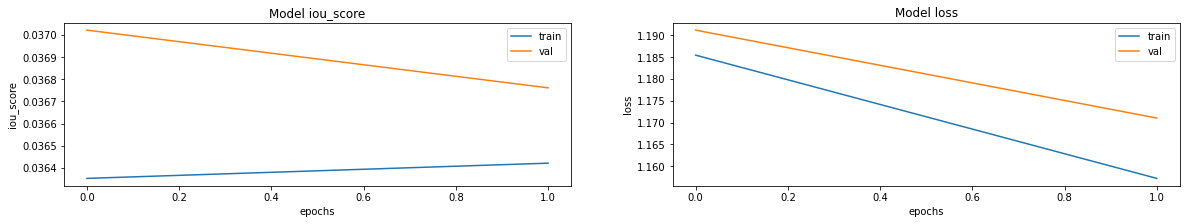

In [11]:
model_name = "unet_vgg"

def train_unet_vgg():

    model.compile(
        optimizer='Adam',
        loss=sm.losses.bce_jaccard_loss,
        metrics=[sm.metrics.iou_score],
    )

    t0 = timer()

    hist = model.fit(train_ds,
                     epochs=n_epochs,
                     verbose=2,
                     validation_data=val_ds,
                     batch_size=batch_size,
                     steps_per_epoch=steps_per_epoch)
    
    t1 = timer() - t0

    process_model(model, hist, model_name, t1)


if not trained:
    train_unet_vgg()
else:
    model.load_weights(f"./models/{model_name}_weights.h5")
    
display_learning_curves(model_name, "iou_score")

In [16]:
def prediction_display():
    pred_df = val_df.head(1)
    pred_ds = tf.data.Dataset.from_tensor_slices(
        (pred_df["original_image_path"].values,
        pred_df["labeled_image_path"].values,)
        ).shuffle(BUFFER_SIZE)
    pred_ds = pred_ds.map(load_imgs, num_parallel_calls=AUTOTUNE)
    pred_ds = pred_ds.batch(1)
    pred = model.predict(pred_ds)
    toimg = np.asarray(pred[0])
    output_img = np.argmax(toimg, axis=2)
    output_img = np.expand_dims(output_img, axis=2)
    cv2.imwrite('output_image.png', output_img)
    img1 = cv2.imread(pred_df.iloc[0]["original_image_path"])
    img2 = cv2.imread('output_image.png', cv2.IMREAD_GRAYSCALE)
    img3 = cv2.imread(pred_df.iloc[0]["labeled_image_path"], cv2.IMREAD_GRAYSCALE) 
    display_imgs(img1, img2, img3)
    
prediction_display()